# Réseau Convolutif sur Pytorch

### Import des library nécessaires

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## Classification sur MNIST

Pour démontrer l'efficacité des réseaux de neurones convolutifs 2D, nous allons commencer par reprendre l'exemple du dataset MNIST de classification de chiffres allant de 0 à 9. Pour cela, nous reprenons le code du notebook précédent et du notebook [TechniquesAvancées](https://github.com/SimonThomine/CoursDeepLearning/blob/main/02_R%C3%A9seauFullyConnected/03_TechniquesAvanc%C3%A9es.ipynb) du cours sur les réseau fully connected. 

### Récuperation du dataset et création des dataloaders pour l'entraînement

In [2]:
transform=T.ToTensor() # Pour convertir les éléments en tensor torch directement
dataset = datasets.MNIST(root='./../data', train=True, download=True,transform=transform)
test_dataset = datasets.MNIST(root='./../data', train=False,transform=transform)

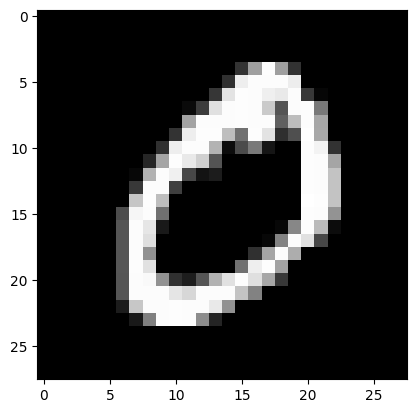

Le chiffre sur l'image est un 0


In [3]:
plt.imshow(dataset[1][0].permute(1,2,0).numpy(), cmap='gray')
plt.show()
print("Le chiffre sur l'image est un "+str(dataset[1][1]))

In [4]:
train_dataset, validation_dataset=torch.utils.data.random_split(dataset, [0.8,0.2])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader= DataLoader(validation_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Création d'un réseau de neurones convolutif en pytorch

In [5]:
class cnn(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.conv1=nn.Conv2d(1,8,kernel_size=3,padding=1) # Couche de convolution de 8 filtres
    self.conv2=nn.Conv2d(8,16,kernel_size=3,padding=1) # Couche de convolution de 16 filtres
    self.conv3=nn.Conv2d(16,32,kernel_size=3,padding=1) # Couche de convolution de 32 filtres
    self.pool1=nn.MaxPool2d((2,2)) # Couche de max pooling 
    self.pool2=nn.MaxPool2d((2,2))
    self.fc=nn.Linear(32*7*7,10)
  
  # La fonction forward est la fonction appelée lorsqu'on fait model(x)
  def forward(self,x):
    x=F.relu(self.conv1(x))
    x=self.pool1(x)
    x=F.relu(self.conv2(x))
    x=self.pool2(x)
    x=F.relu(self.conv3(x))
    x=x.view(-1,32*7*7) # Pour convertir la feature map de taille 32x7x7 en taille vecteur de taille 1568
    output=self.fc(x)
    return output

In [6]:
model = cnn()
print(model)
print("Nombre de paramètres", sum(p.numel() for p in model.parameters()))

cnn(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)
Nombre de paramètres 21578


Comme vous pouvez le constater, le nombre de paramètres du modèle est très faible en comparaison de notre réseau fully connected du [cours précédent](https://github.com/SimonThomine/CoursDeepLearning/blob/main/02_R%C3%A9seauFullyConnected/03_TechniquesAvanc%C3%A9es.ipynb).

### Entraînement du modèle

Définissions la fonction de loss et les hyperparamètres d'entraînement : 

In [7]:
criterion = nn.CrossEntropyLoss()
epochs=5
learning_rate=0.001
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

Et maintenant, entraînons le modèle : 

In [8]:
for i in range(epochs):
  loss_train=0
  for images, labels in train_loader:
    preds=model(images)
    loss=criterion(preds,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train+=loss   
  if i % 1 == 0:
    print(f"step {i} train loss {loss_train/len(train_loader)}")
  loss_val=0    
  for images, labels in val_loader:
    with torch.no_grad(): # permet de ne pas calculer les gradients
      preds=model(images)
      loss=criterion(preds,labels)
      loss_val+=loss 
  if i % 1 == 0:
    print(f"step {i} val loss {loss_val/len(val_loader)}")

step 0 train loss 0.318773478269577
step 0 val loss 0.08984239399433136
step 1 train loss 0.08383051306009293
step 1 val loss 0.0710655003786087
step 2 train loss 0.05604167655110359
step 2 val loss 0.0528845489025116
step 3 train loss 0.04518255963921547
step 3 val loss 0.051780227571725845
step 4 train loss 0.03614392504096031
step 4 val loss 0.0416230633854866


Et calculons la précision sur le jeu de données de test :

In [9]:
correct = 0
total = 0
for images,labels in test_loader: 
  with torch.no_grad():
    preds=model(images)
    
    _, predicted = torch.max(preds.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()     
test_acc = 100 * correct / total
print("Précision du modèle en phase de test : ",test_acc)

Précision du modèle en phase de test :  98.64


Comme vous pouvez le voir, on obtient une précision de presque 99% contre les 97.5% qui nous avions obtenu avec un réseau fully connected contenant 10 fois plus de paramètres. 

### Softmax et interprétation des résultats

Si l'on exécute le modèle sur un élément, on obtiendra un vecteur de ce type :

In [10]:
images,labels=next(iter(test_loader))

#Isolons un élément 
image,label=images[0].unsqueeze(0),labels[0].unsqueeze(0) # Le unsqueeze permet de garder la dimension batch
pred=model(image)
print(pred)

tensor([[ -9.6179,  -5.1802,  -2.6094,   0.9121, -16.0603,  -8.6510, -30.0099,
          14.4031,  -9.0074,  -2.0431]], grad_fn=<AddmmBackward0>)


En regardant attentivement les résultats, on constate que la valeur du 7ème élément est la plus importante donc on peut déduire que le modèle a prédit un 3.  
Vérifions avec notre label : 

In [11]:
print(label)

tensor([7])


Il s'agit bien d'un 7. Cependant, on prefererait avoir une probabilité d'appartenance à la classe. C'est beaucoup plus lisible et ça nous donne un degré de confiance facilement interprétable.

Pour cela, nous utilisons la fonction d'activation *softmax*.  

Cette fonction est définie comme ceci :  
$\sigma(z)_i = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}$ où $K$ est le nombre de classe du modèle.  

Cette fonction est appelée *softmax* car c'est une opération qui amplifie la valeur du maximum tout en réduisant les autres valeurs. On l'utilise pour obtenir une distribution de probabilité car la somme des valeurs pour les $K$ classes est égale à 1. 


In [12]:
print(F.softmax(pred))

tensor([[3.6964e-11, 3.1266e-09, 4.0884e-08, 1.3833e-06, 5.8867e-14, 9.7215e-11,
         5.1481e-20, 1.0000e+00, 6.8068e-11, 7.2027e-08]],
       grad_fn=<SoftmaxBackward0>)


/tmp/ipykernel_232253/3904022211.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(F.softmax(pred))


Les valeurs sont maintenant des probabilités et on voit que 7 est prédit avec une probabilité de 99.9%. Le modèle est donc plutôt confiant sur sa prédiction.

### Autres applications

Les réseaux convolutifs se sont demarqués comme étant particulièrement intéressant dans le domaine du traitement d'images. On les utilise également dans le domaine de l'audio et du traitement vidéo par exemple. 

Les notebooks suivant de ce cours montrent des applications des réseaux convolutifs sur des cas plus intéressant que MNIST. Il est conseillé d'avoir un GPU ou d'utiliser les notebooks sur google colab pour avoir des temps d'entraînement raisonnables (vous pouvez quand même suivre le cours sans faire l'entraînement du modèle).